**Healthcare Dataset Analysis**

*BDA Final Project*

1. Import Pyspark and Load Dataset
2. Conduct EDA and basic visualizations

In [1]:
! pip install pyspark -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import functions as fn

sc = SparkContext.getOrCreate()

spark = SparkSession\
    .builder\
    .appName('Healthcare Dataset')\
    .getOrCreate()

In [3]:
import os
#check working directory
!pwd
!dir

/content
heart_2022_no_nans.csv	sample_data


In [4]:
# load the healthcare dataset,
healthcare = spark.read.csv('heart_2022_no_nans.csv', header=True)

In [5]:
healthcare.show()

+-------+------+-------------+------------------+----------------+--------------------+------------------+----------+--------------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+--------------------+--------------------+---------+---------------------+---------------+--------------+-----------------+-----+---------------+----------+------------+-------------+--------------------+----------------+--------+
|  State|   Sex|GeneralHealth|PhysicalHealthDays|MentalHealthDays|     LastCheckupTime|PhysicalActivities|SleepHours|        RemovedTeeth|HadHeartAttack|HadAngina|HadStroke|HadAsthma|HadSkinCancer|HadCOPD|HadDepressiveDisorder|HadKidneyDisease|HadArthritis|HadDiabetes|DeafOrHardOfHearing|BlindOrVisionDifficulty|DifficultyConcentrating|DifficultyWalking|DifficultyDress

In [6]:
healthcare.printSchema()
healthcare.groupBy("RemovedTeeth").count().show()


root
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: string (nullable = true)
 |-- MentalHealthDays: string (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: string (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- DifficultyConcentrating: string (nullable = t

# A bunch of transformations will help us do ML on this dataset


Transformations:

- Make 6 fields ordinal: LastCheckupTime, GeneralHealth, RemovedTeeth, SmokerStatus, ECigaretteUseage, AgeCategory
- Make 6 ordinal buckets out of: BMI, MentalHealthDays, PhysicalHealthDays,  SleepHours, HeightInMeters, WeightInKilograms
- Make Boolean these 25 categories: HadHeartAttack, HadAngina, HadStroke, HadAsthma, HadSkinCancer, HadCOPD, HadDepressiveDisorder, HadKidneyDisease, HadArthritis, HadDiabetes, PhysicalActivities, DeafOrHardOfHearing, BlindOrVisionDifficulty, DifficultyConcentrating, DifficultyWalking, DifficultyDressingBathing, DifficultyErrands, ChestScan, AlcoholDrinkers, HIVTesting, FluVaxLast12, PneumoVaxEver, TetanusLast10Tdap, HighRiskLastYear, CovidPos_Boolean
- Leave 3 as is: State, Sex, RaceEthnicityCategory
(we could do one-hot encoding for RaceEthnicityCategory)

In [7]:
# 6 ordinal fields conversion
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# Define UDFs for each column's ordinal conversion dictionary

def map_smoker_status(value):
    mapping = {
        'Never smoked': 1,
        'Former smoker': 2,
        'Current smoker - now smokes some days': 3,
        'Current smoker - now smokes every day': 4
    }
    return mapping.get(value, None)

smoker_status_udf = udf(map_smoker_status, IntegerType())

def map_ecigarette_usage(value):
    mapping = {
        'Never used e-cigarettes in my entire life': 1,
        'Not at all (right now)': 2,
        'Use them some days': 3,
        'Use them every day': 4
    }
    return mapping.get(value, None)

ecigarette_usage_udf = udf(map_ecigarette_usage, IntegerType())

def map_age_category(value):
    mapping = {
        'Age 18 to 24': 1,
        'Age 25 to 29': 2,
        'Age 30 to 34': 3,
        'Age 35 to 39': 4,
        'Age 40 to 44': 5,
        'Age 45 to 49': 6,
        'Age 50 to 54': 7,
        'Age 55 to 59': 8,
        'Age 60 to 64': 9,
        'Age 65 to 69': 10,
        'Age 70 to 74': 11,
        'Age 75 to 79': 12,
        'Age 80 or older': 13
    }
    return mapping.get(value, None)

age_category_udf = udf(map_age_category, IntegerType())

def map_last_checkup_time(value):
    mapping = {
        'Within past year (anytime less than 12 months ago)': 1,
        'Within past 2 years (1 year but less than 2 years ago)': 2,
        'Within past 5 years (2 years but less than 5 years ago)': 3,
        '5 or more years ago': 4,
        'Never': 5
    }
    return mapping.get(value, None)

last_checkup_time_udf = udf(map_last_checkup_time, IntegerType())

def map_general_health(value):
    mapping = {
        'Excellent': 1,
        'Very good': 2,
        'Good': 3,
        'Fair': 4,
        'Poor': 5
    }
    return mapping.get(value, None)

general_health_udf = udf(map_general_health, IntegerType())

def map_removed_teeth(value):
    mapping = {
        'None of them': 1,
        '1 to 5': 2,
        '6 or more, but not all': 3,
        'All': 4
    }
    return mapping.get(value, None)

removed_teeth_udf = udf(map_removed_teeth, IntegerType())

# Apply the UDFs to convert to ordinal values
healthcare = healthcare.withColumn('SmokerStatus_Ordinal', smoker_status_udf(fn.col('SmokerStatus')))
healthcare = healthcare.withColumn('ECigaretteUsage_Ordinal', ecigarette_usage_udf(fn.col('ECigaretteUsage')))
healthcare = healthcare.withColumn('AgeCategory_Ordinal', age_category_udf(fn.col('AgeCategory')))
healthcare = healthcare.withColumn('LastCheckupTime_Ordinal', last_checkup_time_udf(fn.col('LastCheckupTime')))
healthcare = healthcare.withColumn('GeneralHealth_Ordinal', general_health_udf(fn.col('GeneralHealth')))
healthcare = healthcare.withColumn('RemovedTeeth_Ordinal', removed_teeth_udf(fn.col('RemovedTeeth')))

# Show the result to verify
healthcare.select(
    'SmokerStatus', 'SmokerStatus_Ordinal',
    'ECigaretteUsage', 'ECigaretteUsage_Ordinal',
    'AgeCategory', 'AgeCategory_Ordinal',
    'LastCheckupTime', 'LastCheckupTime_Ordinal',
    'GeneralHealth', 'GeneralHealth_Ordinal',
    'RemovedTeeth', 'RemovedTeeth_Ordinal'
).show()


+--------------------+--------------------+--------------------+-----------------------+---------------+-------------------+--------------------+-----------------------+-------------+---------------------+--------------------+--------------------+
|        SmokerStatus|SmokerStatus_Ordinal|     ECigaretteUsage|ECigaretteUsage_Ordinal|    AgeCategory|AgeCategory_Ordinal|     LastCheckupTime|LastCheckupTime_Ordinal|GeneralHealth|GeneralHealth_Ordinal|        RemovedTeeth|RemovedTeeth_Ordinal|
+--------------------+--------------------+--------------------+-----------------------+---------------+-------------------+--------------------+-----------------------+-------------+---------------------+--------------------+--------------------+
|       Former smoker|                   2|Never used e-ciga...|                      1|   Age 65 to 69|                 10|Within past year ...|                      1|    Very good|                    2|        None of them|                   1|
|       

In [8]:
# Fix all the boolean fields to work better with ML
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType
from pyspark.sql import functions as fn

# Define the UDF to convert string values to boolean
def to_boolean(value):
    return value == 'Yes'

to_boolean_udf = udf(to_boolean, BooleanType())

# List of columns to convert to boolean
boolean_columns = [
    'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer',
    'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
    'HadDiabetes', 'PhysicalActivities', 'DeafOrHardOfHearing',
    'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking',
    'DifficultyDressingBathing', 'DifficultyErrands', 'ECigaretteUsage',
    'ChestScan', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12',
    'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear'
]

# Loop through each column and apply the UDF
for col in boolean_columns:
    new_col_name = f'{col}_Bool'
    healthcare = healthcare.withColumn(new_col_name, to_boolean_udf(fn.col(col)))

# I will accept home tests for Covid
healthcare = healthcare.withColumn(
    'CovidPos_Boolean',
    fn.when(
        (fn.col('CovidPos') == 'Yes') | (fn.col('CovidPos') == 'HomeTestPositive'),
        1
    ).otherwise(0)
)


# Now all 25 yes/no columns will be converted to duplicate corresponding boolean columns
healthcare.show()

+-------+------+-------------+------------------+----------------+--------------------+------------------+----------+--------------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+--------------------+--------------------+---------+---------------------+---------------+--------------+-----------------+-----+---------------+----------+------------+-------------+--------------------+----------------+--------+--------------------+-----------------------+-------------------+-----------------------+---------------------+--------------------+-------------------+--------------+--------------+--------------+------------------+------------+--------------------------+---------------------+-----------------+----------------+-----------------------+------------------------+---------

Transform the 6 ordinal bucket columns separately: BMI, MentalHealthDays, PhysicalHealthDays,  SleepHours, HeightInMeters, WeightInKilograms

In [9]:
# Calculate the mean and standard deviation of BMI
mean_bmi = healthcare.agg(fn.mean('BMI')).collect()[0][0]
stddev_bmi = healthcare.agg(fn.stddev('BMI')).collect()[0][0]

# Create BMI Buckets using Standard Deviations
healthcare = healthcare.withColumn(
    'BMI_Bucket',
    fn.when((fn.col('BMI') >= mean_bmi - 2*stddev_bmi) & (fn.col('BMI') < mean_bmi - stddev_bmi), 'Far Below Average')
    .when((fn.col('BMI') >= mean_bmi - stddev_bmi) & (fn.col('BMI') < mean_bmi), 'Below Average')
    .when((fn.col('BMI') >= mean_bmi) & (fn.col('BMI') < mean_bmi + stddev_bmi), 'Above Average')
    .otherwise('Far Above Average')
)

# Assign ordinal values to BMI Buckets
healthcare = healthcare.withColumn(
    'BMI_Bucket_Ordinal',
    fn.when(fn.col('BMI_Bucket') == 'Far Below Average', 1)
    .when(fn.col('BMI_Bucket') == 'Below Average', 2)
    .when(fn.col('BMI_Bucket') == 'Above Average', 3)
    .otherwise(4)
)

# Group by BMI Bucket and count occurrences in each bucket
healthcare.groupBy('BMI_Bucket', 'BMI_Bucket_Ordinal').count().orderBy('BMI_Bucket_Ordinal').show()


+-----------------+------------------+-----+
|       BMI_Bucket|BMI_Bucket_Ordinal|count|
+-----------------+------------------+-----+
|Far Below Average|                 1| 4915|
|    Below Average|                 2|18554|
|    Above Average|                 3|11749|
|Far Above Average|                 4| 5664|
+-----------------+------------------+-----+



In [10]:

# HeightInMeters Ordinal Binning
mean_height = healthcare.agg(fn.mean('HeightInMeters')).collect()[0][0]
stddev_height = healthcare.agg(fn.stddev('HeightInMeters')).collect()[0][0]

healthcare = healthcare.withColumn(
    'Height_Bucket',
    fn.when((fn.col('HeightInMeters') >= mean_height - 2*stddev_height) & (fn.col('HeightInMeters') < mean_height - stddev_height), 'Far Below Average')
    .when((fn.col('HeightInMeters') >= mean_height - stddev_height) & (fn.col('HeightInMeters') < mean_height), 'Below Average')
    .when((fn.col('HeightInMeters') >= mean_height) & (fn.col('HeightInMeters') < mean_height + stddev_height), 'Above Average')
    .otherwise('Far Above Average')
)

healthcare = healthcare.withColumn(
    'Height_Bucket_Ordinal',
    fn.when(fn.col('Height_Bucket') == 'Far Below Average', 1)
    .when(fn.col('Height_Bucket') == 'Below Average', 2)
    .when(fn.col('Height_Bucket') == 'Above Average', 3)
    .otherwise(4)
)

# Group by Height Bucket and count occurrences in each bucket
healthcare.groupBy('Height_Bucket', 'Height_Bucket_Ordinal').count().orderBy('Height_Bucket_Ordinal').show()


+-----------------+---------------------+-----+
|    Height_Bucket|Height_Bucket_Ordinal|count|
+-----------------+---------------------+-----+
|Far Below Average|                    1| 5576|
|    Below Average|                    2|16285|
|    Above Average|                    3|11763|
|Far Above Average|                    4| 7258|
+-----------------+---------------------+-----+



In [11]:
# Exclude rows where MentalHealthDays is 0 for recalculating the mean and stddev
healthcare_non_zero = healthcare.filter(fn.col('MentalHealthDays') > 0)

# Calculate mean and stddev for non-zero MentalHealthDays
mean_mental_health = healthcare_non_zero.agg(fn.mean('MentalHealthDays')).collect()[0][0]
stddev_mental_health = healthcare_non_zero.agg(fn.stddev('MentalHealthDays')).collect()[0][0]

# Recreate the MentalHealthDays Bucket, excluding 0 days from bins
healthcare = healthcare.withColumn(
    'MentalHealthDays_Bucket',
    fn.when(fn.col('MentalHealthDays') == 0, 'Zero')
    .when((fn.col('MentalHealthDays') > 0) & (fn.col('MentalHealthDays') < mean_mental_health - stddev_mental_health), 'Far Below Average')
    .when((fn.col('MentalHealthDays') >= mean_mental_health - stddev_mental_health) & (fn.col('MentalHealthDays') < mean_mental_health), 'Below Average')
    .when((fn.col('MentalHealthDays') >= mean_mental_health) & (fn.col('MentalHealthDays') < mean_mental_health + stddev_mental_health), 'Above Average')
    .otherwise('Far Above Average')
)
# Assign Ordinal values to MentalHealthDays Buckets, treating Zero as its own category
healthcare = healthcare.withColumn(
    'MentalHealthDays_Ordinal',
    fn.when(fn.col('MentalHealthDays_Bucket') == 'Zero', 0)
    .when(fn.col('MentalHealthDays_Bucket') == 'Far Below Average', 1)
    .when(fn.col('MentalHealthDays_Bucket') == 'Below Average', 2)
    .when(fn.col('MentalHealthDays_Bucket') == 'Above Average', 3)
    .otherwise(4)
)

healthcare.groupBy('MentalHealthDays_Bucket', 'MentalHealthDays_Ordinal').agg(
    fn.min('MentalHealthDays').alias('Min MentalHealthDays'),
    fn.max('MentalHealthDays').alias('Max MentalHealthDays'),
    fn.count('*').alias('Count')
).orderBy('MentalHealthDays_Ordinal').show()



+-----------------------+------------------------+--------------------+--------------------+-----+
|MentalHealthDays_Bucket|MentalHealthDays_Ordinal|Min MentalHealthDays|Max MentalHealthDays|Count|
+-----------------------+------------------------+--------------------+--------------------+-----+
|                   Zero|                       0|                 0.0|                 0.0|24628|
|          Below Average|                       2|                 1.0|                 9.0|10655|
|          Above Average|                       3|                11.0|                20.0| 2662|
|      Far Above Average|                       4|                21.0|                30.0| 2937|
+-----------------------+------------------------+--------------------+--------------------+-----+



In [12]:
# Create a new column for zero and non-zero PhysicalHealthDays
healthcare = healthcare.withColumn(
    'PhysicalHealthDays_Zero',
    fn.when(fn.col('PhysicalHealthDays') == 0, 'Zero')
    .otherwise('Non-Zero')
)

# For Non-Zero values, calculate mean and stddev
non_zero_healthcare = healthcare.filter(fn.col('PhysicalHealthDays') != 0)
mean_physical_health_days = non_zero_healthcare.agg(fn.mean('PhysicalHealthDays')).collect()[0][0]
stddev_physical_health_days = non_zero_healthcare.agg(fn.stddev('PhysicalHealthDays')).collect()[0][0]

# Create PhysicalHealthDays Buckets for Non-Zero values
healthcare = healthcare.withColumn(
    'PhysicalHealthDays_Bucket',
    fn.when(fn.col('PhysicalHealthDays') == 0, 'Zero')
    .when((fn.col('PhysicalHealthDays') >= mean_physical_health_days - 2*stddev_physical_health_days) & (fn.col('PhysicalHealthDays') < mean_physical_health_days - stddev_physical_health_days), 'Far Below Average')
    .when((fn.col('PhysicalHealthDays') >= mean_physical_health_days - stddev_physical_health_days) & (fn.col('PhysicalHealthDays') < mean_physical_health_days), 'Below Average')
    .when((fn.col('PhysicalHealthDays') >= mean_physical_health_days) & (fn.col('PhysicalHealthDays') < mean_physical_health_days + stddev_physical_health_days), 'Above Average')
    .otherwise('Far Above Average')
)

# Assign Ordinal values to PhysicalHealthDays Buckets, treating Zero as its own category
healthcare = healthcare.withColumn(
    'PhysicalHealthDays_Ordinal',
    fn.when(fn.col('PhysicalHealthDays_Bucket') == 'Zero', 0)
    .when(fn.col('PhysicalHealthDays_Bucket') == 'Far Below Average', 1)
    .when(fn.col('PhysicalHealthDays_Bucket') == 'Below Average', 2)
    .when(fn.col('PhysicalHealthDays_Bucket') == 'Above Average', 3)
    .otherwise(4)
)

# Group by PhysicalHealthDays Bucket and count occurrences in each bucket
healthcare.groupBy('PhysicalHealthDays_Bucket', 'PhysicalHealthDays_Ordinal').agg(
    fn.min('PhysicalHealthDays').alias('Min PhysicalHealthDays'),
    fn.max('PhysicalHealthDays').alias('Max PhysicalHealthDays'),
    fn.count('*').alias('Count')
).orderBy('PhysicalHealthDays_Ordinal').show()


+-------------------------+--------------------------+----------------------+----------------------+-----+
|PhysicalHealthDays_Bucket|PhysicalHealthDays_Ordinal|Min PhysicalHealthDays|Max PhysicalHealthDays|Count|
+-------------------------+--------------------------+----------------------+----------------------+-----+
|                     Zero|                         0|                   0.0|                   0.0|24986|
|            Below Average|                         2|                   1.0|                   9.0|10423|
|            Above Average|                         3|                  12.0|                  21.0| 2158|
|        Far Above Average|                         4|                  22.0|                  30.0| 3315|
+-------------------------+--------------------------+----------------------+----------------------+-----+



# These last two ordinal buckets below have a skew due to a low mode and a higher mean.  It's just because of the larger range of outliers to the upside.

In [13]:
# Check the distribution of SleepHours before binning
healthcare.groupBy('SleepHours').count().orderBy('SleepHours').show()


+----------+-----+
|SleepHours|count|
+----------+-----+
|       1.0|   96|
|      10.0|  968|
|      11.0|   61|
|      12.0|  261|
|      13.0|   17|
|      14.0|   39|
|      15.0|   25|
|      16.0|   33|
|      18.0|   13|
|      19.0|    1|
|       2.0|  137|
|      20.0|    7|
|      23.0|    2|
|      24.0|    3|
|       3.0|  246|
|       4.0| 1072|
|       5.0| 2579|
|       6.0| 9013|
|       7.0|12469|
|       8.0|11776|
+----------+-----+
only showing top 20 rows



In [14]:
# SleepHours Ordinal Binning
mean_sleep = healthcare.agg(fn.mean('SleepHours')).collect()[0][0]
stddev_sleep = healthcare.agg(fn.stddev('SleepHours')).collect()[0][0]

healthcare = healthcare.withColumn(
    'SleepHours_Bucket',
    fn.when((fn.col('SleepHours') >= mean_sleep - 2*stddev_sleep) & (fn.col('SleepHours') < mean_sleep - stddev_sleep), 'Far Below Average')
    .when((fn.col('SleepHours') >= mean_sleep - stddev_sleep) & (fn.col('SleepHours') < mean_sleep), 'Below Average')
    .when((fn.col('SleepHours') >= mean_sleep) & (fn.col('SleepHours') < mean_sleep + stddev_sleep), 'Above Average')
    .otherwise('Far Above Average')
)

healthcare = healthcare.withColumn(
    'SleepHours_Bucket_Ordinal',
    fn.when(fn.col('SleepHours_Bucket') == 'Far Below Average', 1)
    .when(fn.col('SleepHours_Bucket') == 'Below Average', 2)
    .when(fn.col('SleepHours_Bucket') == 'Above Average', 3)
    .otherwise(4)
)

# Group by SleepHours Bucket and count occurrences in each bucket
healthcare.groupBy('SleepHours_Bucket', 'SleepHours_Bucket_Ordinal').count().orderBy('SleepHours_Bucket_Ordinal').show()




+-----------------+-------------------------+-----+
|SleepHours_Bucket|SleepHours_Bucket_Ordinal|count|
+-----------------+-------------------------+-----+
|Far Below Average|                        1| 2579|
|    Below Average|                        2|21482|
|    Above Average|                        3|11776|
|Far Above Average|                        4| 5045|
+-----------------+-------------------------+-----+



In [15]:
# WeightInKilograms Ordinal Binning
mean_weight = healthcare.agg(fn.mean('WeightInKilograms')).collect()[0][0]
stddev_weight = healthcare.agg(fn.stddev('WeightInKilograms')).collect()[0][0]

healthcare = healthcare.withColumn(
    'Weight_Bucket',
    fn.when((fn.col('WeightInKilograms') >= mean_weight - 2*stddev_weight) & (fn.col('WeightInKilograms') < mean_weight - stddev_weight), 'Far Below Average')
    .when((fn.col('WeightInKilograms') >= mean_weight - stddev_weight) & (fn.col('WeightInKilograms') < mean_weight), 'Below Average')
    .when((fn.col('WeightInKilograms') >= mean_weight) & (fn.col('WeightInKilograms') < mean_weight + stddev_weight), 'Above Average')
    .otherwise('Far Above Average')
)

healthcare = healthcare.withColumn(
    'Weight_Bucket_Ordinal',
    fn.when(fn.col('Weight_Bucket') == 'Far Below Average', 1)
    .when(fn.col('Weight_Bucket') == 'Below Average', 2)
    .when(fn.col('Weight_Bucket') == 'Above Average', 3)
    .otherwise(4)
)

# Group by Weight Bucket and count occurrences in each bucket
healthcare.groupBy('Weight_Bucket', 'Weight_Bucket_Ordinal').count().orderBy('Weight_Bucket_Ordinal').show()


+-----------------+---------------------+-----+
|    Weight_Bucket|Weight_Bucket_Ordinal|count|
+-----------------+---------------------+-----+
|Far Below Average|                    1| 6008|
|    Below Average|                    2|16944|
|    Above Average|                    3|11797|
|Far Above Average|                    4| 6133|
+-----------------+---------------------+-----+



In [16]:
# I can't get this to print out right, the high end shows up wrong, but the data is sorted right!
# Group by Weight Bucket and show the ranges
healthcare.groupBy('Weight_Bucket', 'Weight_Bucket_Ordinal').agg(
    fn.min('WeightInKilograms').alias('Min WeightInKilograms'),
    fn.max('WeightInKilograms').alias('Max WeightInKilograms'),
    fn.count('*').alias('Count')
).orderBy('Weight_Bucket_Ordinal').show()


+-----------------+---------------------+---------------------+---------------------+-----+
|    Weight_Bucket|Weight_Bucket_Ordinal|Min WeightInKilograms|Max WeightInKilograms|Count|
+-----------------+---------------------+---------------------+---------------------+-----+
|Far Below Average|                    1|                 41.0|                61.69| 6008|
|    Below Average|                    2|                 62.0|                82.55|16944|
|    Above Average|                    3|                100.0|                99.79|11797|
|Far Above Average|                    4|               103.42|                40.82| 6133|
+-----------------+---------------------+---------------------+---------------------+-----+



So here are the derived columns for the ordinals, the bucket ordinals, the booleans and the originals: State, Sex, RaceEthnicityCategory, BMI_Bucket Ordinal, Height_Bucket_Ordinal, MentalHealthDays_Ordinal, PhysicalHealthDays Ordinal, HadHeartAttack_Bool, HadAngina_Bool, HadStroke_Bool, HadAsthma_Bool, HadSkinCancer_Bool, HadCOPD_Bool, HadDepressiveDisorder_Bool, HadKidneyDisease_Bool, HadArthritis_Bool, HadDiabetes_Bool, PhysicalActivities_Bool, DeafOrHardOfHearing_Bool, BlindOrVisionDifficulty_Bool, DifficultyConcentrating_Bool, DifficultyWalking_Bool, DifficultyDressingBathing_Bool, DifficultyErrands_Bool, ECigaretteUsage_Bool, ChestScan_Bool, AlcoholDrinkers_Bool, HIVTesting_Bool, FluVaxLast12_Bool, PneumoVaxEver_Bool, TetanusLast10Tdap_Bool, HighRiskLastYear_Bool, CovidPos_Boolean, LastCheckupTime_Ordinal, GeneralHealth_Ordinal, RemovedTeeth_Ordinal, SmokerStatus_Ordinal, ECigaretteUsage_Ordinal, AgeCategory_Ordinal, SleepHours_Bucket_Ordinal, Weight Bucket_Ordinal


# This just out of curiosity, I had looked at a few things before transformations were done


In [17]:
# This just out of curiosity, I looked at a few things before transformations were done
grouped_by_age_bucket = healthcare.groupBy('AgeCategory').agg(
    fn.count('*').alias('Count'),
    fn.round(fn.avg('SleepHours'), 2).alias('AvgSleepHours')
)

grouped_by_age_bucket.orderBy('AgeCategory').show()


+---------------+-----+-------------+
|    AgeCategory|Count|AvgSleepHours|
+---------------+-----+-------------+
|   Age 18 to 24| 2055|          7.0|
|   Age 25 to 29| 1842|         6.91|
|   Age 30 to 34| 2313|         6.87|
|   Age 35 to 39| 2554|         6.78|
|   Age 40 to 44| 2670|         6.75|
|   Age 45 to 49| 2684|         6.82|
|   Age 50 to 54| 3255|         6.88|
|   Age 55 to 59| 3596|         6.92|
|   Age 60 to 64| 4415|          7.0|
|   Age 65 to 69| 4745|         7.19|
|   Age 70 to 74| 4395|         7.26|
|   Age 75 to 79| 3245|         7.39|
|Age 80 or older| 3113|         7.48|
+---------------+-----+-------------+



<ipython-input-18-53ce4009fc9f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AgeCategory', y='AvgSleepHours', data=grouped_by_age_bucket_pd, palette='Set2')


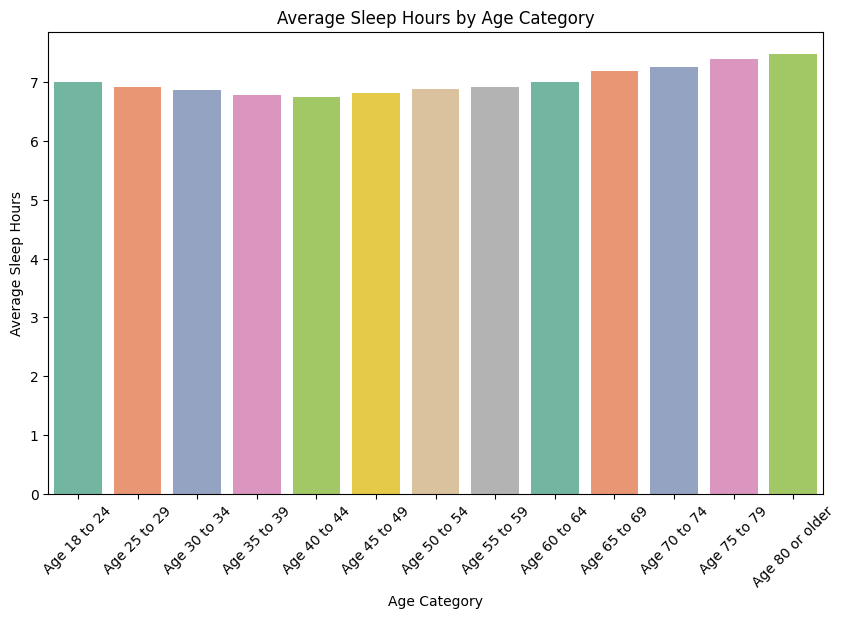

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Spark DataFrame to a Pandas DataFrame
grouped_by_age_bucket_pd = grouped_by_age_bucket.orderBy('AgeCategory').toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='AgeCategory', y='AvgSleepHours', data=grouped_by_age_bucket_pd, palette='Set2')
plt.title('Average Sleep Hours by Age Category')
plt.ylabel('Average Sleep Hours')
plt.xlabel('Age Category')
plt.xticks(rotation=45)
plt.show()


In [19]:
# Summary statistics for numerical columns
healthcare.select('HeightInMeters', 'WeightInKilograms', 'BMI', 'SleepHours').describe().show()

# Frequency counts for categorical variables
healthcare.groupBy('GeneralHealth').count().orderBy('count', ascending=False).show()

# Cross-tabulation
healthcare.crosstab('Sex', 'SmokerStatus').show()

+-------+-------------------+------------------+------------------+-----------------+
|summary|     HeightInMeters| WeightInKilograms|               BMI|       SleepHours|
+-------+-------------------+------------------+------------------+-----------------+
|  count|              40882|             40882|             40882|            40882|
|   mean| 1.7053935717430773| 82.57388826378293|28.308871630546538|7.047111198082286|
| stddev|0.10694923070070793|20.825609178595155|6.3697226479327815|1.459005498081065|
|    min|               0.91|             100.0|             12.48|              1.0|
|    max|               2.36|             99.79|             97.65|              9.0|
+-------+-------------------+------------------+------------------+-----------------+

+-------------+-----+
|GeneralHealth|count|
+-------------+-----+
|    Very good|14255|
|         Good|12591|
|    Excellent| 7235|
|         Fair| 5124|
|         Poor| 1677|
+-------------+-----+

+----------------+--------

# New Section

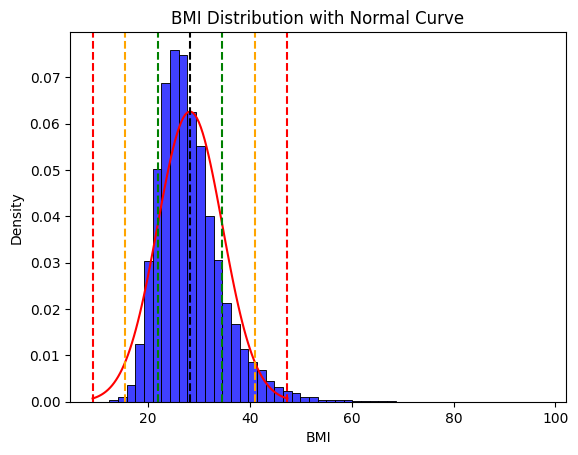

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import functions as fn
import pandas as pd

# Convert BMI data into a pandas DataFrame
bmi_data = healthcare.select("BMI").toPandas()

# Convert BMI data to numeric, forcing errors to NaN
bmi_data["BMI"] = pd.to_numeric(bmi_data["BMI"], errors='coerce')

# Drop NaN values that resulted from conversion errors
bmi_data = bmi_data.dropna()

# Calculate mean and std deviation
mean_bmi = bmi_data["BMI"].mean()
stddev_bmi = bmi_data["BMI"].std()

# Plot histogram of BMIs
sns.histplot(bmi_data["BMI"], bins=50, kde=False, color='blue', stat='density')

# Generate normal distribution curve based on mean and stddev
x = np.linspace(mean_bmi - 3*stddev_bmi, mean_bmi + 3*stddev_bmi, 100)
plt.plot(x, (1/(stddev_bmi * np.sqrt(2 * np.pi))) * np.exp(-(x - mean_bmi)**2 / (2 * stddev_bmi**2)), color='red')

# Mark 1st, 2nd, and 3rd standard deviations
plt.axvline(mean_bmi, color='black', linestyle='--')
plt.axvline(mean_bmi + stddev_bmi, color='green', linestyle='--')
plt.axvline(mean_bmi - stddev_bmi, color='green', linestyle='--')
plt.axvline(mean_bmi + 2*stddev_bmi, color='orange', linestyle='--')
plt.axvline(mean_bmi - 2*stddev_bmi, color='orange', linestyle='--')
plt.axvline(mean_bmi + 3*stddev_bmi, color='red', linestyle='--')
plt.axvline(mean_bmi - 3*stddev_bmi, color='red', linestyle='--')

# Add labels and title
plt.title("BMI Distribution with Normal Curve")
plt.xlabel("BMI")
plt.ylabel("Density")

# Show the plot
plt.show()

The right skew is to be expected with this BMI data, since outliers on the high end can go much further from the median than low BMI outliers.  With the mean so different from the mode it is tempting to re-plot around it, but then standard deviation would loose its meaning, so we will not.

In [21]:
from pyspark.sql import functions as fn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by BMI Bucket and calculate counts for Heart Attack and Angina data
heart_attack_data = healthcare.groupBy('BMI_Bucket', 'HadHeartAttack').count()
angina_data = healthcare.groupBy('BMI_Bucket', 'HadAngina').count()

# Calculate the ratios
heart_attack_ratio = heart_attack_data.groupBy('BMI_Bucket').agg(
    fn.sum(fn.when(fn.col('HadHeartAttack') == 'Yes', fn.col('count')).otherwise(0)).alias('Yes'),
    fn.sum(fn.when(fn.col('HadHeartAttack') == 'No', fn.col('count')).otherwise(0)).alias('No')
)
heart_attack_ratio = heart_attack_ratio.withColumn('Ratio', heart_attack_ratio['Yes'] / (heart_attack_ratio['Yes'] + heart_attack_ratio['No']))

angina_ratio = angina_data.groupBy('BMI_Bucket').agg(
    fn.sum(fn.when(fn.col('HadAngina') == 'Yes', fn.col('count')).otherwise(0)).alias('Yes'),
    fn.sum(fn.when(fn.col('HadAngina') == 'No', fn.col('count')).otherwise(0)).alias('No')
)
angina_ratio = angina_ratio.withColumn('Ratio', angina_ratio['Yes'] / (angina_ratio['Yes'] + angina_ratio['No']))

# Convert the data to Pandas to plot it
heart_attack_ratio_pd = heart_attack_ratio.toPandas()
angina_ratio_pd = angina_ratio.toPandas()

# Reordering the buckets intuitively
bucket_order = ['Far Below Average', 'Below Average', 'Above Average', 'Far Above Average']
heart_attack_ratio_pd['BMI_Bucket'] = pd.Categorical(heart_attack_ratio_pd['BMI_Bucket'], categories=bucket_order, ordered=True)
angina_ratio_pd['BMI_Bucket'] = pd.Categorical(angina_ratio_pd['BMI_Bucket'], categories=bucket_order, ordered=True)


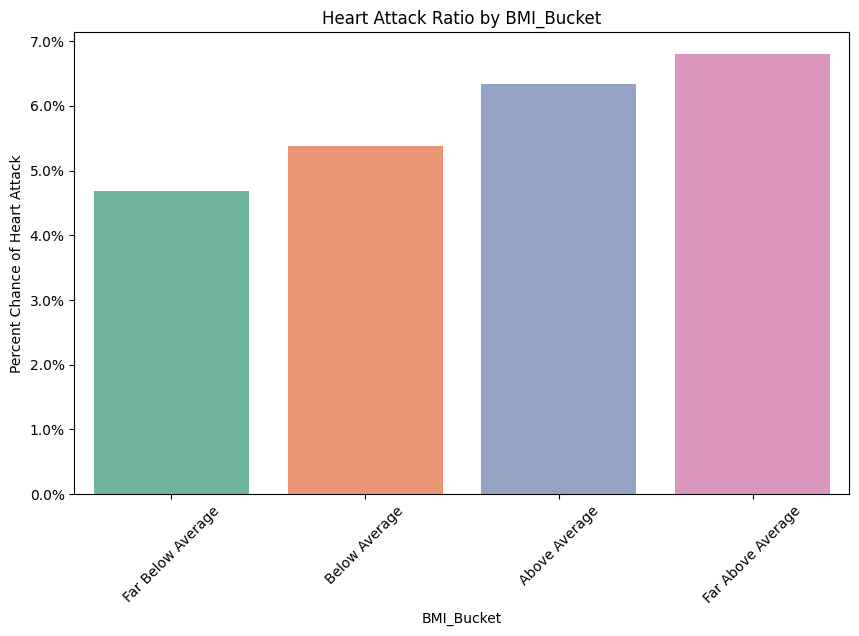

In [22]:
import matplotlib.ticker as mtick

plt.figure(figsize=(10, 6))
sns.barplot(x='BMI_Bucket', y='Ratio', hue='BMI_Bucket', data=heart_attack_ratio_pd, palette='Set2')
plt.title('Heart Attack Ratio by BMI_Bucket')
plt.ylabel('Percent Chance of Heart Attack')
plt.xlabel('BMI_Bucket')
plt.xticks(rotation=45)

# Use FuncFormatter to format the y-axis as percentages
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.show()


Heart attacks increase with BMI.

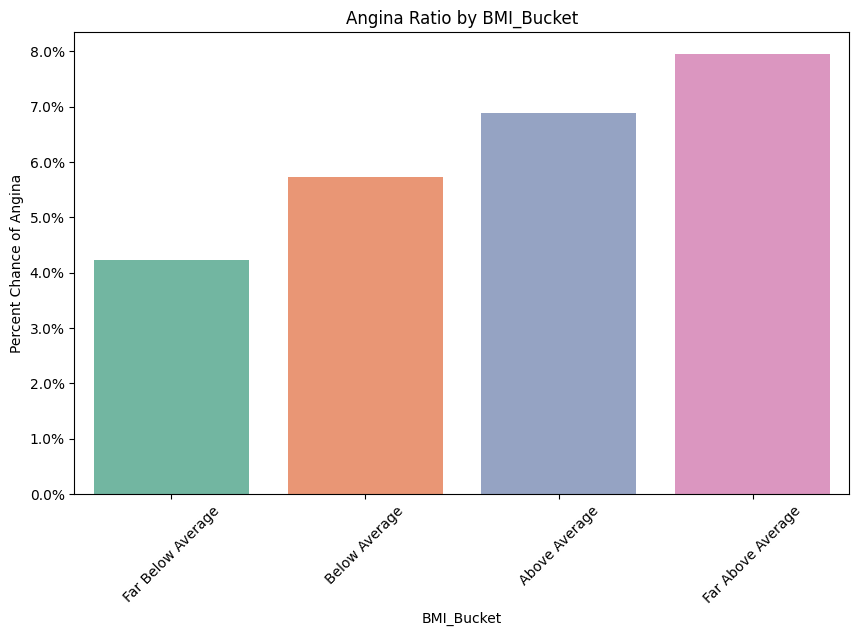

In [23]:
import matplotlib.ticker as mtick

plt.figure(figsize=(10, 6))
sns.barplot(x='BMI_Bucket', y='Ratio', hue='BMI_Bucket', data=angina_ratio_pd, palette='Set2')
plt.title('Angina Ratio by BMI_Bucket')
plt.ylabel('Percent Chance of Angina')
plt.xlabel('BMI_Bucket')
plt.xticks(rotation=45)

# Use FuncFormatter to format the y-axis as percentages
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.show()


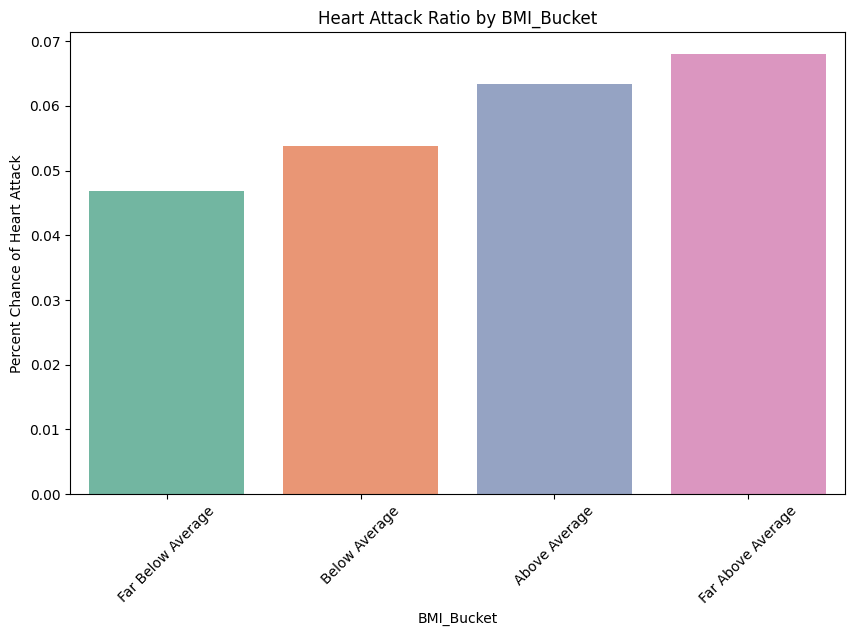

Chest pain from the heart increases with BMI.

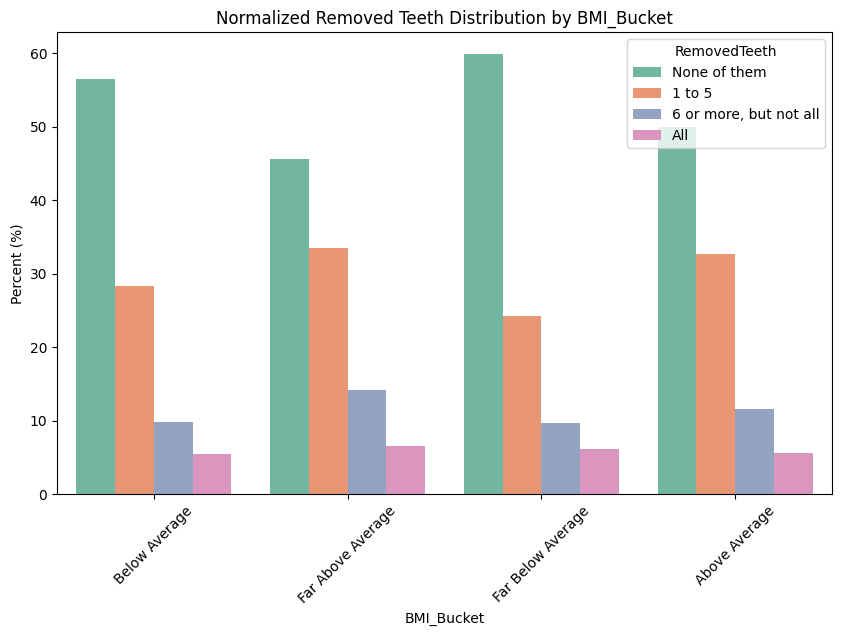

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the data to a Pandas DataFrame
bmi_teeth_data = healthcare.groupBy("BMI_Bucket", "RemovedTeeth").count().toPandas()

# Reorder BMI Bucket categories
bmi_teeth_data['BMI Bucket'] = pd.Categorical(bmi_teeth_data['BMI_Bucket'],
                                              categories=['Far Below Average', 'Below Average', 'Above Average', 'Far Above Average'],
                                              ordered=True)

# Calculate the percentage within each bucket
# Reset the index of the result from apply to align with the DataFrame
bmi_teeth_data['Percent'] = bmi_teeth_data.groupby('BMI_Bucket', observed=False)['count'].apply(lambda x: 100 * x / float(x.sum())).reset_index(level=0, drop=True)

# Plotting the normalized percentages
plt.figure(figsize=(10, 6))
sns.barplot(x='BMI_Bucket', y='Percent', hue='RemovedTeeth', data=bmi_teeth_data, palette='Set2')
plt.title('Normalized Removed Teeth Distribution by BMI_Bucket')
plt.ylabel('Percent (%)')
plt.xlabel('BMI_Bucket')
plt.xticks(rotation=45)
plt.show()

Looks like having teeth pulled is a risk of rising BMI as well.  While half the cohort had none pulled, the exact ratios varied with BMI.  None pulled goes down and down, while some or many pulled goes up and up.

# Logistic Regression, Gradient Boosting Classifier (and one hot transformation)

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define feature columns and target column
features = [
    'State', 'Sex', 'RaceEthnicityCategory', 'BMI_Bucket_Ordinal', 'Height_Bucket_Ordinal',
    'MentalHealthDays_Ordinal', 'PhysicalHealthDays_Ordinal', 'PhysicalActivities_Bool',
    'DeafOrHardOfHearing_Bool', 'BlindOrVisionDifficulty_Bool', 'DifficultyConcentrating_Bool',
    'DifficultyWalking_Bool', 'DifficultyDressingBathing_Bool', 'DifficultyErrands_Bool',
    'ECigaretteUsage_Bool', 'ChestScan_Bool', 'AlcoholDrinkers_Bool', 'HIVTesting_Bool',
    'FluVaxLast12_Bool', 'PneumoVaxEver_Bool', 'TetanusLast10Tdap_Bool', 'HighRiskLastYear_Bool',
    'CovidPos_Boolean', 'LastCheckupTime_Ordinal', 'GeneralHealth_Ordinal', 'RemovedTeeth_Ordinal',
    'SmokerStatus_Ordinal', 'ECigaretteUsage_Ordinal', 'AgeCategory_Ordinal', 'SleepHours_Bucket_Ordinal',
    'Weight_Bucket_Ordinal'
]

# Set target variable
target = 'HadHeartAttack_Bool'  # Or use 'HadAngina_Bool'

# Convert PySpark DataFrame to Pandas DataFrame
X_pd = healthcare[features].toPandas()
y_pd = healthcare.select(target).toPandas()

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pd, y_pd, test_size=0.2, random_state=777)

# Identify numerical and categorical features
numeric_features = X_train.select_dtypes(include=['number']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Create transformers for numerical and categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Use ColumnTransformer to apply different transformers to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform the training data
X_train_scaled = preprocessor.fit_transform(X_train)

# Transform the test data
X_test_scaled = preprocessor.transform(X_test)

# Initialize a Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Fit the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9416656475480005
              precision    recall  f1-score   support

       False       0.94      1.00      0.97      7708
        True       0.21      0.01      0.01       469

    accuracy                           0.94      8177
   macro avg       0.58      0.50      0.49      8177
weighted avg       0.90      0.94      0.92      8177

[[7697   11]
 [ 466    3]]


Noteably, Logistic regression fails for the minority class, .39 is low precision, .01 recall is extrememly low and .02 f1-score, also extremely low

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=777)

# Fit the model on the training data
gb_model.fit(X_train_scaled, y_train.values.ravel())

# Make predictions on the test set
y_pred_gb = gb_model.predict(X_test_scaled)

# Evaluate the model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy: {accuracy_gb}")
print(classification_report(y_test, y_pred_gb))
print(confusion_matrix(y_test, y_pred_gb))


Accuracy: 0.9416656475480005
              precision    recall  f1-score   support

       False       0.94      1.00      0.97      7708
        True       0.25      0.01      0.02       469

    accuracy                           0.94      8177
   macro avg       0.60      0.50      0.49      8177
weighted avg       0.90      0.94      0.92      8177

[[7696   12]
 [ 465    4]]


In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Calculate scale_pos_weight to balance the classes
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Initialize XGBoost model with scale_pos_weight
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, n_estimators=100, random_state=777)

# Fit the model on the training data
xgb_model.fit(X_train_scaled, y_train.values.ravel())

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb}")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost Accuracy: 0.9395866454689984
              precision    recall  f1-score   support

       False       0.94      0.99      0.97      7708
        True       0.28      0.03      0.06       469

    accuracy                           0.94      8177
   macro avg       0.61      0.51      0.51      8177
weighted avg       0.91      0.94      0.92      8177

[[7667   41]
 [ 453   16]]


In [28]:
from sklearn.model_selection import GridSearchCV

# Extend the parameter ranges until they stop improving the result
param_grid = {
    'n_estimators': [800],
    'learning_rate': [ 1.7, 1.65],
    'max_depth': [15],
    'min_child_weight': [10],
    'gamma': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [ 1]
}

xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=777)

grid_search = GridSearchCV(xgb, param_grid, scoring='f1', cv=3, verbose=1)
grid_search.fit(X_train_scaled, y_train.values.ravel())

print("Best hyperparameters:", grid_search.best_params_)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best hyperparameters: {'colsample_bytree': 1, 'gamma': 0.1, 'learning_rate': 1.7, 'max_depth': 15, 'min_child_weight': 10, 'n_estimators': 800, 'subsample': 0.8}


Best hyperparameters: {'colsample_bytree': 1, 'gamma': 0.1, 'learning_rate': 1.65, 'max_depth': 15, 'min_child_weight': 10, 'n_estimators': 800, 'subsample': 0.8}



In [29]:

# Initialize the model with the best hyperparameters
xgb_best = XGBClassifier(
    colsample_bytree=1,
    gamma=0.1,
    learning_rate=1.65,
    max_depth=15,
    min_child_weight=10,
    n_estimators=800,
    subsample=0.8,
    random_state=777
)

# Fit the model on the training data
xgb_best.fit(X_train_scaled, y_train.values.ravel())

# Make predictions on the test set
y_pred = xgb_best.predict(X_test_scaled)

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)


Model Accuracy: 0.894826953650483
Confusion Matrix:
[[7238  470]
 [ 390   79]]
Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.94      0.94      7708
        True       0.14      0.17      0.16       469

    accuracy                           0.89      8177
   macro avg       0.55      0.55      0.55      8177
weighted avg       0.90      0.89      0.90      8177



In [30]:
# Now to adjust the threshold:
# Get prediction probabilities
y_pred_prob = xgb_best.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for the positive class

threshold = 0.001                                          # Default was 0.5
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)   # Converts the probabilities into class predictions based on threshold

# Re-evaluate with new threshold
print(confusion_matrix(y_test, y_pred_adjusted))
print(classification_report(y_test, y_pred_adjusted))


[[6323 1385]
 [ 285  184]]
              precision    recall  f1-score   support

       False       0.96      0.82      0.88      7708
        True       0.12      0.39      0.18       469

    accuracy                           0.80      8177
   macro avg       0.54      0.61      0.53      8177
weighted avg       0.91      0.80      0.84      8177



In [31]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

# Initialize SMOTE
smote = SMOTE(random_state=777)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Initialize Gradient Boosting model
gb_model_smote = GradientBoostingClassifier(n_estimators=100, random_state=777)

# Fit the model on the resampled data
gb_model_smote.fit(X_train_resampled, y_train_resampled.values.ravel())

# Make predictions on the test set
y_pred_smote = gb_model_smote.predict(X_test_scaled)

# Evaluate the model
accuracy_smote = accuracy_score(y_test, y_pred_smote)
print(f"SMOTE Gradient Boosting Accuracy: {accuracy_smote}")
print(classification_report(y_test, y_pred_smote))
print(confusion_matrix(y_test, y_pred_smote))


SMOTE Gradient Boosting Accuracy: 0.9220985691573926
              precision    recall  f1-score   support

       False       0.95      0.97      0.96      7708
        True       0.26      0.19      0.22       469

    accuracy                           0.92      8177
   macro avg       0.61      0.58      0.59      8177
weighted avg       0.91      0.92      0.92      8177

[[7450  258]
 [ 379   90]]


In [32]:
# Get prediction probabilities
y_pred_prob_smote = gb_model_smote.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for the positive class

# Set the threshold below 0.5
threshold = 0.25
y_pred_adjusted_smote = (y_pred_prob_smote >= threshold).astype(int)

# Re-evaluate with the new threshold
print("Confusion Matrix with Threshold 0.25:")
print(confusion_matrix(y_test, y_pred_adjusted_smote))

print("Classification Report with Threshold 0.25:")
print(classification_report(y_test, y_pred_adjusted_smote))


Confusion Matrix with Threshold 0.25:
[[6021 1687]
 [ 157  312]]
Classification Report with Threshold 0.25:
              precision    recall  f1-score   support

       False       0.97      0.78      0.87      7708
        True       0.16      0.67      0.25       469

    accuracy                           0.77      8177
   macro avg       0.57      0.72      0.56      8177
weighted avg       0.93      0.77      0.83      8177



Not impressed with the GBC results.  I'll try to improve the Logistic Regression with hyperparameters, class weight and SMOTE separately and then together

In [33]:
# Initialize Logistic Regression with class weights
log_reg_model = LogisticRegression(class_weight='balanced', max_iter=1000)

# Fit the model on the training data
log_reg_model.fit(X_train_scaled, y_train.values.ravel())

# Make predictions
y_pred_lr = log_reg_model.predict(X_test_scaled)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy with Class Weight: {accuracy_lr}")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))


Logistic Regression Accuracy with Class Weight: 0.7168888345358934
              precision    recall  f1-score   support

       False       0.98      0.71      0.83      7708
        True       0.14      0.77      0.24       469

    accuracy                           0.72      8177
   macro avg       0.56      0.74      0.53      8177
weighted avg       0.93      0.72      0.79      8177

[[5500 2208]
 [ 107  362]]


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define parameter grid for Logistic Regression
param_grid = {
    'C': [11, 13, 15],  # Regularization parameter
    'solver': ['liblinear'],  # Solvers to try
    'max_iter': [500]  # Maximum iterations
}

# Initialize Logistic Regression with class weights
log_reg = LogisticRegression(class_weight='balanced')

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Fit the model on the original training data (WITHOUT SMOTE)
grid_search.fit(X_train_scaled, y_train.values.ravel())

# Get best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1-Score: {grid_search.best_score_}")

# Use the best estimator for predictions
best_log_reg = grid_search.best_estimator_
y_pred_best_lr = best_log_reg.predict(X_test_scaled)

# Evaluate the model
accuracy_best_lr = accuracy_score(y_test, y_pred_best_lr)
print(f"Best Logistic Regression Accuracy: {accuracy_best_lr}")
print(classification_report(y_test, y_pred_best_lr))
print(confusion_matrix(y_test, y_pred_best_lr))


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'C': 11, 'max_iter': 500, 'solver': 'liblinear'}
Best F1-Score: 0.23390197797113318
Best Logistic Regression Accuracy: 0.7168888345358934
              precision    recall  f1-score   support

       False       0.98      0.71      0.83      7708
        True       0.14      0.77      0.24       469

    accuracy                           0.72      8177
   macro avg       0.56      0.74      0.53      8177
weighted avg       0.93      0.72      0.79      8177

[[5500 2208]
 [ 107  362]]


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'C': 11, 'max_iter': 500, 'solver': 'liblinear'}
Best F1-Score: 0.2637252647581475
Best Logistic Regression Accuracy: 0.7314907021644141
              precision    recall  f1-score   support

       False       0.98      0.73      0.84     46158
        True       0.16      0.79      0.27      3047

    accuracy                           0.73     49205
   macro avg       0.57      0.76      0.55     49205
weighted avg       0.93      0.73      0.80     49205

[[33586 12572]
 [  640  2407]]

Results above show small improvements using hyperparameter tuning, class weights and threshold adjustment for logistic regression.  Best result still logistic regression with SMOTE.  Let's try the Angina target variable.

In [35]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

target = 'HadAngina_Bool'

# Split the data into features (X) and target (y)
X = healthcare[features].toPandas()
y = healthcare.select(target).toPandas()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

# Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['number']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Create a preprocessor to handle both scaling numerical data and encoding categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Apply the preprocessor to the training and test sets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE to the training data
smote = SMOTE(random_state=777)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# Initialize Logistic Regression with class weights
log_reg_model = LogisticRegression(class_weight='balanced', max_iter=1000)

# Fit the model on the resampled training data
log_reg_model.fit(X_train_resampled, y_train_resampled.values.ravel())

# Make predictions on the test set
y_pred = log_reg_model.predict(X_test_preprocessed)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression with SMOTE Accuracy (Angina): {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Logistic Regression with SMOTE Accuracy (Angina): 0.7525987525987526
              precision    recall  f1-score   support

       False       0.98      0.75      0.85      7678
        True       0.17      0.78      0.28       499

    accuracy                           0.75      8177
   macro avg       0.57      0.76      0.56      8177
weighted avg       0.93      0.75      0.82      8177

[[5767 1911]
 [ 112  387]]


Comparable predictive results for heart attacks and angina using linear regression with class weights and SMOTE implemented.  I like the relatively high recall.  Useful results for health councelling.